# PlantEx
## Vesicle detection, clustering and quantificaiton in 2D and 3D
---
Analysis of represenative example for 2D and 3D data
* Each code block can be executed by "SHIFT+Enter"

### 0. import Python packages

In [2]:
import os
import numpy
import pandas
import tifffile

import seaborn as sns
from skimage import filters, feature

from matplotlib import pyplot as plt

# Import main functions for vesicle analysis
from plantEx_code.vesicles import detect_and_cluster, isolated_points, crop_at, crop_at_2d, fit_gaussian2d, fit_gaussian2d_iso, fit_gaussian3d, fit_gaussian3d_iso


### 1. Vesicle detection and clustering 3D
---

In [3]:
img_fn_3d = "data/sample_volume_01.tif"
img_fn_3d_pixel_size_in_nm = 100

detect_and_cluster(): sample_volume_01
  -- found total peaks: 925
  -- found clusters: 18
  -- cluster sizes: [17 27 18 49 13 19 33 17 10 14 23 27 18 10 14 20 14 19]


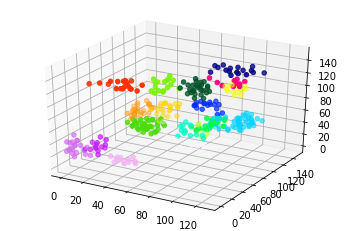

In [4]:
vesicles_clustered = detect_and_cluster(img_fn_3d)

In [6]:
# detected vesicles table; labels indicate cluster assignment
# dim0:dim2 refer to the coordinates of the detected vesicle
vesicles_clustered

dim0  dim1  dim2  labels  intensity
0     110    81   149       2   0.967005
1       9    13    25      17   0.903270
2      92    41   108       1   0.877255
3      88    19   125       1   0.853333
4      75    15    66       1   0.842310
..    ...   ...   ...     ...        ...
920    78   115    52       1   0.097408
921    92    85   149       2   0.097301
922    90   149    92       1   0.097274
923    19   134    13      19   0.097203
924    16    82     0       1   0.096794

[925 rows x 5 columns]

### 2. Full-width at half-maximum for isolated vesicles (anisotropic Gaussian fit)

In [7]:
fn = os.path.splitext(img_fn_3d)[0]
fn_dir = os.path.dirname(img_fn_3d)

# Read original image
img = tifffile.imread(fn + ".tif")

# Read detected clusters
tab = pandas.read_csv(fn + "_clusters.tab", "\t")

# filter for isolated points with distance 7px
ctab = isolated_points(tab, 7)

res_aniso = []
cluster = []
for i, row in ctab.iterrows():
    try:
        crop = crop_at(img, *row["dim0":"dim2"].tolist(), radius=3)
    except AssertionError:
        continue

    para, ok = fit_gaussian3d(crop)

    if ((para[1:4] > 1) & (para[1:4] < crop.shape[0]-1)).all():
        res_aniso.append(para)
        cluster.append(int(row.labels)-1)
        
res_aniso = numpy.array(res_aniso)[:,4:]
res_aniso = pandas.DataFrame(res_aniso*2.355*img_fn_3d_pixel_size_in_nm, columns=["FWHM Z", "FWHM Y", "FWHM X"]) 
res_aniso["cluster"] = cluster 
res_aniso.to_csv(fn + "_FWHM_aniso.tab", "\t")


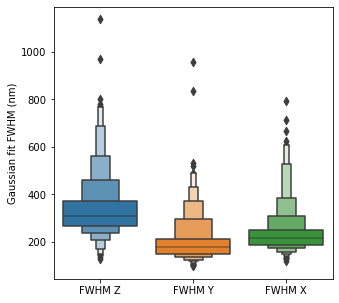

In [12]:
# Scale refers to physical size after expansion 
# for vesicle sizes refering to the original tissue size, 
# these should be divided by the expansion factor
f = plt.figure(figsize=(5,5))
#sns.violinplot(data=res_aniso)
plt.ylabel("Gaussian fit FWHM (nm)");

sns.boxenplot(data=res_aniso[[f"FWHM {d}" for d in "ZYX"]])

### 3. Full-width at half-maximum for isolated vesicles (isotropic Gaussian fit)

In [ ]:
fn = os.path.splitext(img_fn_3d)[0]

img = tifffile.imread(fn + ".tif")
tab = pandas.read_csv(fn + "_clusters.tab", "\t")

# filter for isolated points with distance 7px
ctab = isolated_points(tab, 7)

res_iso = []
for i, row in ctab.iterrows():
    try:
        crop = crop_at(img, *row["dim0":"dim2"].tolist(), radius=3)
    except AssertionError:
        continue

    para = fit_gaussian3d_iso(crop)

    if ((para[1:4] > 1) & (para[1:4] < crop.shape[0]-1)).all():
        res_iso.append(para)
        
res_iso = numpy.array(res_iso)
res_iso = pandas.DataFrame(res_iso, columns=["height", "mz", "my", "mx", "std"])

res_iso["FWHM"] = res_iso["std"] * 2.355 * img_fn_3d_pixel_size_in_nm

In [ ]:
# Scale refers to physical size after expansion 
# for vesicle sizes refering to the original tissue size, 
# these should be divided by the expansion factor
f = plt.figure(figsize=(2,5))
sns.violinplot(y="FWHM", data=res_iso)
plt.ylabel("Gaussian fit FWHM (nm)");

### 4. Vesicle detection and quantification 2D

In [ ]:
img_fn_2d = "data/sample_2D_STED.tif"
img_fn_2d_pixel_size_in_nm = 30

In [ ]:
img_2d = tifffile.imread(img_fn_2d).astype("float32")
img_2d_norm = (img_2d - img_2d.min()) / (numpy.percentile(img_2d, 99.9) - img_2d.min())

In [ ]:
img_filt = filters.gaussian(img_2d_norm, 0.5, preserve_range=True)

In [ ]:
peaks_ind = feature.peak_local_max(img_filt, min_distance=2, threshold_rel=0.25, indices=True, exclude_border=True)
peaks_2d_df = pandas.DataFrame({"y": peaks_ind[:,1], "x": peaks_ind[:,0]})

# filter for isolated points with distance 10px
peaks_2d_isol_df = isolated_points(peaks_2d_df, min_dist=10, coords=["y", "x"])

plt.figure(figsize=(12,12))
plt.imshow(img_2d, 'hot', vmax=16384)
plt.plot(peaks_2d_isol_df.y, peaks_2d_isol_df.x, 'co', markerfacecolor="none")
plt.title("Detected, isolated vesicles");

In [ ]:
cres = []
for i, row in peaks_2d_isol_df.iterrows():
    try:
        crop = crop_at_2d(img_2d, row["x"], row["y"], radius=5)
    except AssertionError:
        continue

    para = fit_gaussian2d_iso(crop)

    if ((para[1:3] > 1) & (para[1:3] < crop.shape[0]-1)).all():
        cres.append(para)
    
res_2d = pandas.DataFrame(2.355 * img_fn_2d_pixel_size_in_nm * numpy.array(cres)[:, -1], columns=["FWHM"])

In [ ]:
# Scale refers to physical size after expansion 
# for vesicle sizes refering to the original tissue size, 
# these should be divided by the expansion factor
f = plt.figure(figsize=(2,5))
sns.barplot(data=res_2d, ci="sd")
plt.ylabel("Gaussian fit FWHM (nm)");